In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [12]:
df_trainval = pd.read_csv("./development.csv")
df_test = pd.read_csv("./evaluation.csv")

## Preprocessing

We see the presence of a na in both title and article. if they are from the same id we can remove the all row altogether, otherwise it may still contain valuable information and we only replace the missing column with an empty string

In [13]:
df_trainval.values[np.argmax(df_trainval['title'].isna()),:]


array([26038, 'Forbes', nan, '\\N', 5, '2004-11-19 23:47:53', 1],
      dtype=object)

no title but not article either, i can drop it

In [14]:
df_trainval['title'].dropna(inplace=True)

no article but still a title, i can use it

In [15]:
df_trainval.values[np.argmax(df_trainval['article'].isna()),:]
df_trainval['article'].fillna('',inplace=True)

/tmp/ipykernel_4473/1246389770.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_trainval['article'].fillna('',inplace=True)


Drop duplicates, casefold, strip spaces, links and other crap

In [16]:
df_trainval['title'].str.casefold().str.strip()
df_trainval['article'].str.casefold().str.strip()

df_trainval.drop_duplicates(subset = 'article', inplace=True)

X_trainval = df_trainval['title'] + ' ' + df_trainval['title'] + ' ' + df_trainval['article']
y_trainval = df_trainval['label']

In [17]:
X_train, X_val, y_train, y_val = train_test_split(
  X_trainval,
  y_trainval,
  test_size= .2,
  random_state=42,
  stratify=y_trainval
)

it is necessary to stratify over y since classes are not evenly distributed

<BarContainer object of 7 artists>

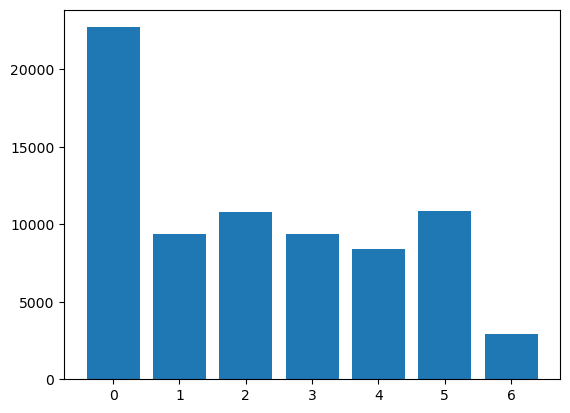

In [18]:
from collections import Counter

plt.bar(Counter(y_trainval).keys(),Counter(y_trainval).values())

In [ ]:
pipe = Pipeline([
  ('tfidf', TfidfVectorizer()),
  ('rf', RandomForestClassifier(random_state=42, warm_start=True))
])

parameter_space = {
  'tfidf__ngram_range': [(1, 1), (1, 2)],
  'tfidf__max_df': [0.5, 0.9],
  'tfidf__min_df': [1, 10],
  'tfidf__max_features': [5000,10000],

  'rf__n_estimators': [100, 150],
  'rf__max_features': [100, 200],
        }
grid_search = GridSearchCV(
  pipe,
  parameter_space,
  cv = 2,
  n_jobs = 1,
  verbose = 1
)
grid_search.fit(X_train,y_train)

Fitting 2 folds for each of 96 candidates, totalling 192 fits


KeyboardInterrupt: 

In [ ]:
tfidf = TfidfVectorizer(
  
)